## Exploratory Data Analysis

### Environment setting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import chi2, mutual_info_regression, f_classif, mutual_info_classif
from sklearn.metrics import classification_report
import sys

In [14]:
# to load custom libraries
LIBRARY_PATH = "."
sys.path.append(LIBRARY_PATH)

# load custom libraries
from utilsPlots import plot_density, plot_bars, na_plot, heatmap_triangle, heatmap_threshold, plot_stat_vs_mi_num, plot_stat_vs_mi_cat, plot_density_cat
from utilsStats import cramers_v, eta_squared

### Load data

In [15]:
# load data
df_train = pd.read_csv('data/train.csv')
# number samples and features
print(f'Number of samples {df_train.shape[0]}')
print(f'Number of features {df_train.shape[1]}')

Number of samples 8693
Number of features 14


In [16]:
# view data
df_train.head().T

,0,1,2,3,4
PassengerId,0001_01,0002_01,0003_01,0003_02,0004_01
HomePlanet,Europa,Earth,Europa,Europa,Earth
CryoSleep,False,False,False,False,False
Cabin,B/0/P,F/0/S,A/0/S,A/0/S,F/1/S
Destination,TRAPPIST-1e,TRAPPIST-1e,TRAPPIST-1e,TRAPPIST-1e,TRAPPIST-1e
Age,39.0,24.0,58.0,33.0,16.0
VIP,False,False,True,False,False
RoomService,0.0,109.0,43.0,0.0,303.0
FoodCourt,0.0,9.0,3576.0,1283.0,70.0
ShoppingMall,0.0,25.0,0.0,371.0,151.0


In [17]:
# distribution of target values
print(f'Number True values: {df_train["Transported"].sum()}')
print(f'Number False values: {(~df_train["Transported"]).sum()}')

Number True values: 4378
Number False values: 4315


### Duplicated samples

In [18]:
# duplicated samples
dupl = sum(df_train.duplicated(['PassengerId']))
print(f'Number of duplicated ID: {dupl}')

Number of duplicated ID: 0


Some names are duplicated, but the rest of the variables are different, so they are considered non-duplicate samples.

In [19]:
# duplicated Name
df = df_train[~df_train['Name'].isna()]
df[df.duplicated(['Name'], keep = False)].sort_values('Name').head(6)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
7270,7775_01,Europa,False,C/253/P,55 Cancri e,28.0,False,7.0,489.0,0.0,4.0,6027.0,Alraium Disivering,False
6296,6665_01,Europa,True,B/222/P,55 Cancri e,17.0,False,0.0,0.0,0.0,0.0,0.0,Alraium Disivering,True
476,0512_02,Europa,True,D/18/S,TRAPPIST-1e,55.0,False,0.0,0.0,0.0,0.0,0.0,Ankalik Nateansive,True
2930,3176_01,Europa,False,E/196/P,TRAPPIST-1e,77.0,False,0.0,9032.0,0.0,128.0,1464.0,Ankalik Nateansive,True
8488,9071_01,Earth,False,F/1855/P,55 Cancri e,22.0,False,0.0,0.0,1072.0,46.0,3.0,Anton Woody,False
2991,3236_03,Earth,False,E/200/P,TRAPPIST-1e,18.0,False,0.0,30.0,0.0,756.0,5.0,Anton Woody,False


### NA values distribution

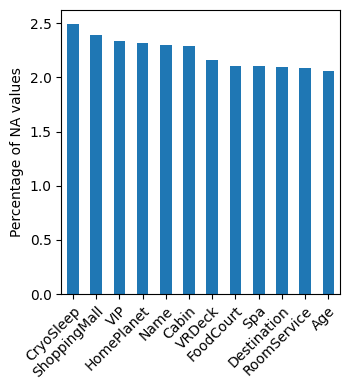

CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Name            200
Cabin           199
VRDeck          188
FoodCourt       183
Spa             183
Destination     182
RoomService     181
Age             179
PassengerId       0
Transported       0
dtype: int64


In [20]:
# NA values
na_plot(df_train)
# distribution of NA values in features
print(df_train.isnull().sum().sort_values(ascending=False))

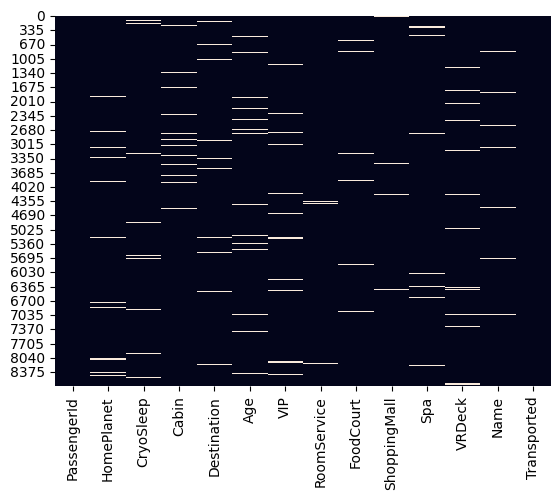

In [21]:
# NA by feature and sample
sns.heatmap(df_train.isna(), cbar=False)
plt.show()

In [22]:
# distribution of NA values in sample
df = df_train.drop(['PassengerId','Transported'], axis = 1)
na_perc = df.isna().sum(axis = 1)/len(df.columns)
print('\nDistribution of NA in samples')
print(na_perc.describe())
print(f'Percentage of samples without NA values: {int(sum(na_perc != 0)/df_train.shape[0]*100)}%')


Distribution of NA in samples
count    8693.000000
mean        0.022278
std         0.042027
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         0.250000
dtype: float64
Percentage of samples without NA values: 24%


### Feature 'Deck'

Feature 'Deck' is splitted into three features 'Deck', 'Num' and 'Side'

In [35]:
# process Cabin feature (takes the form deck/num/side, where side can be either P for Port or S for Starboard)
df_train[['Deck','Num','Side']] = df_train['Cabin'].str.split('/', expand = True)
# TODO Convert to int keeping NAs
#df_train['Num'] = df_train['Num'].astype(int)

In [34]:
# TODO Where to put it
print("Num from 'Cabin' feature distribution")
print(df_train[~df_train['Num'].isna()]['Num'].astype(int).describe())

Num from 'Cabin' feature distribution
count    8494.000000
mean      600.367671
std       511.867226
min         0.000000
25%       167.250000
50%       427.000000
75%       999.000000
max      1894.000000
Name: Num, dtype: float64


### Feature 'Name'

There is no useful information in the passengers' names.

In [36]:
df_train[['FirstName','Surname']] = df_train['Name'].str.split(' ', expand = True)
print(f'Number of different surnames: {df_train["Surname"].unique().shape[0]}')

Number of different surnames: 2218


### Feature exploration

#### Feature 'Age'

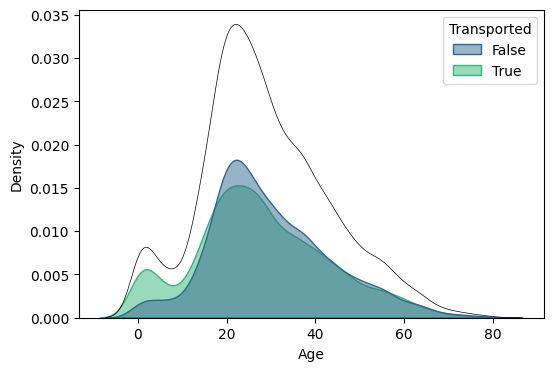

count    8514.000000
mean       28.827930
std        14.489021
min         0.000000
25%        19.000000
50%        27.000000
75%        38.000000
max        79.000000
Name: Age, dtype: float64


In [23]:
# visualize 'Age' feature
plot_density_cat(df_train, ['Age'], 'Transported',  1, 1)
print(df_train['Age'].describe())

#### Feautes related to expenses

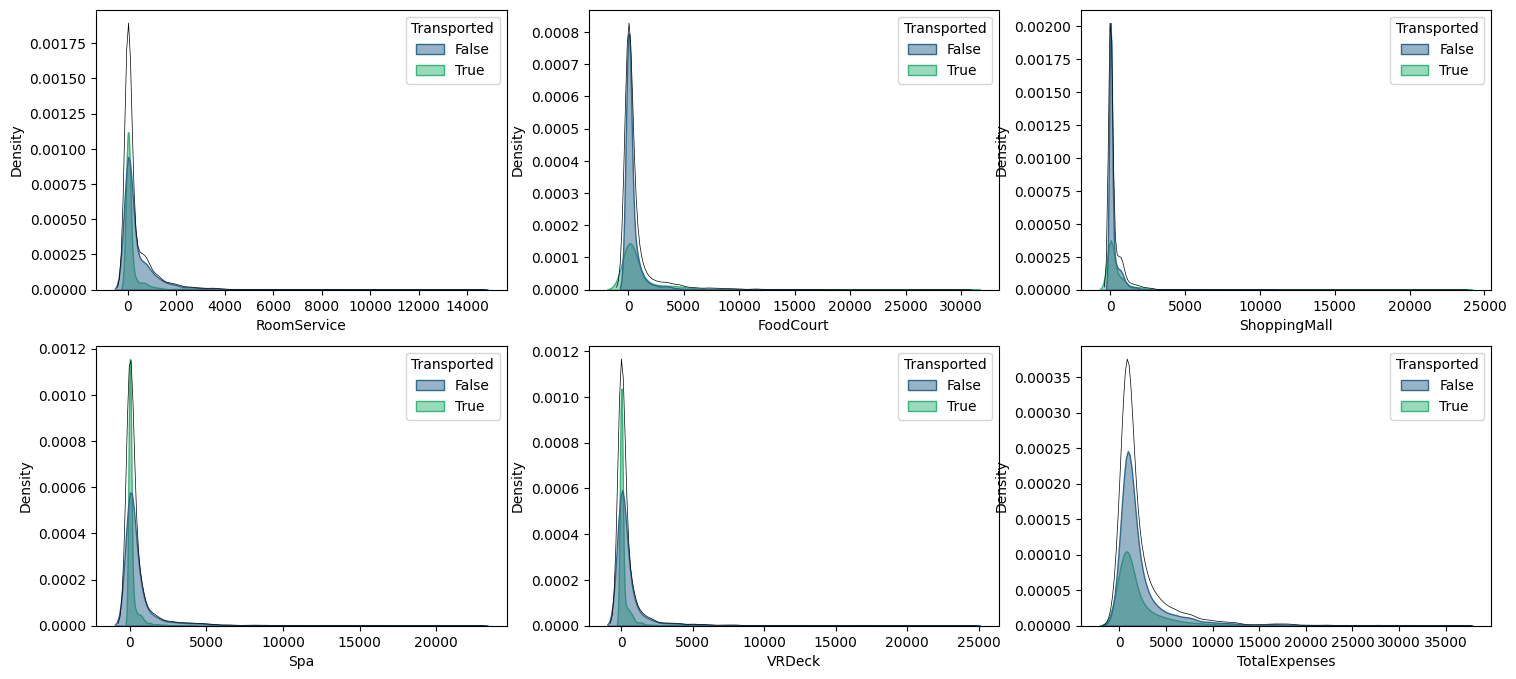

        RoomService     FoodCourt  ShoppingMall           Spa        VRDeck  \
count   5328.000000   5329.000000   5335.000000   5326.000000   5320.000000   
mean     350.146772    713.004316    270.586504    486.092940    475.716165   
std      803.080320   1970.547985    741.756155   1396.233751   1404.174304   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        3.000000      5.000000      2.000000      7.000000      4.000000   
75%      390.250000    537.000000    242.000000    354.750000    356.000000   
max    14327.000000  29813.000000  23492.000000  22408.000000  24133.000000   

       TotalExpenses  
count    5439.000000  
mean     2248.299687  
std      3245.061489  
min         0.000000  
25%       746.000000  
50%      1019.000000  
75%      2416.000000  
max     35987.000000  


In [24]:
# visualize 'RoomService', 'FoodCourt', 'Spa' and 'VRDeck' and new feature 'TotalExpenses'
expense_features = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
# calculate TotalExpenses features
df_train['TotalExpenses'] = df_train[expense_features].sum(axis=1)
# remove samples with CryoSleep True (expenses equal to zero)
df = df_train[df_train['CryoSleep'] == False][expense_features + ['TotalExpenses','Transported']]
plot_density_cat(df, ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck','TotalExpenses'], 'Transported', 2, 3)
print(df.describe())

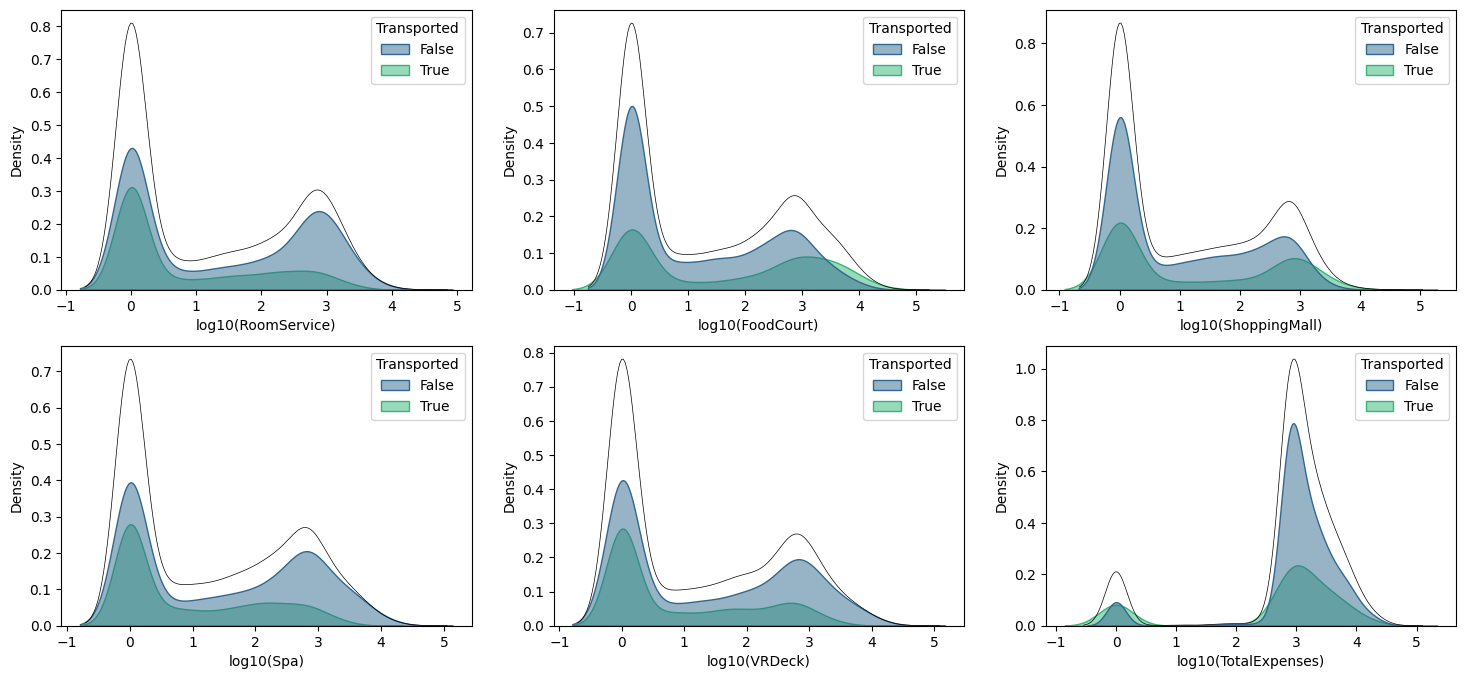

       log10(RoomService)  log10(FoodCourt)  log10(ShoppingMall)   log10(Spa)  \
count         5328.000000       5329.000000          5335.000000  5326.000000   
mean             1.199528          1.314941             1.106717     1.273267   
std              1.298383          1.391035             1.234381     1.305025   
min              0.000000          0.000000             0.000000     0.000000   
25%              0.000000          0.000000             0.000000     0.000000   
50%              0.602060          0.778151             0.477121     0.903090   
75%              2.592454          2.730782             2.385606     2.551145   
max              4.156186          4.474420             4.370938     4.350422   

       log10(VRDeck)  log10(TotalExpenses)  
count    5320.000000           5439.000000  
mean        1.219092              2.881298  
std         1.310807              1.010899  
min         0.000000              0.000000  
25%         0.000000              2.873321  


In [25]:
# visualize 'RoomService', 'FoodCourt', 'Spa' and 'VRDeck' and new feature 'TotalExpenses'
expense_features_log10 = list(map(lambda x: 'log10(' + x + ')', expense_features + ['TotalExpenses']))
# apply log10
df_train[expense_features_log10] = df_train[expense_features + ['TotalExpenses']].apply(lambda x: np.log10(x + 1))
# remove samples with CryoSleep True (expenses equal to zero)
df = df_train[df_train['CryoSleep'] == False][expense_features_log10 + ['Transported']]
plot_density_cat(df, expense_features_log10, 'Transported', 2, 3)
print(df.describe())

#### Categorical features

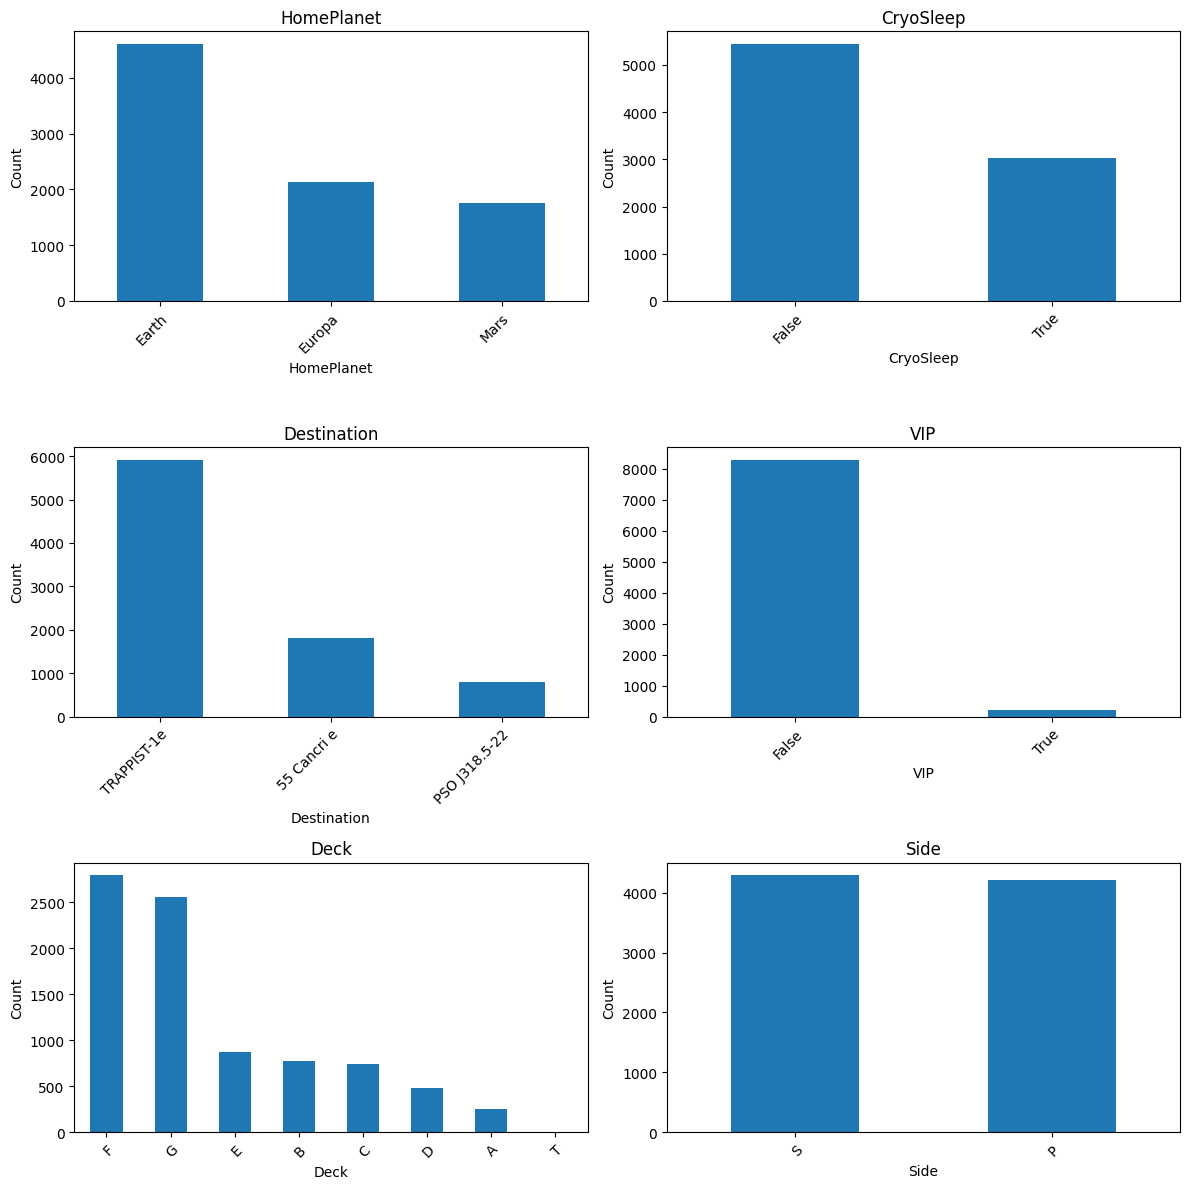

In [33]:
# visualize HomePlanet, CryoSleep, Destination, VIP
# TODO plot with 'Transported'
cat_features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side']
plot_bars(df_train, cat_features, 3, 2, sort = True, log = False)

### Correlation between explanatory features

#### Numerical features (Pearson correlation coeficient)

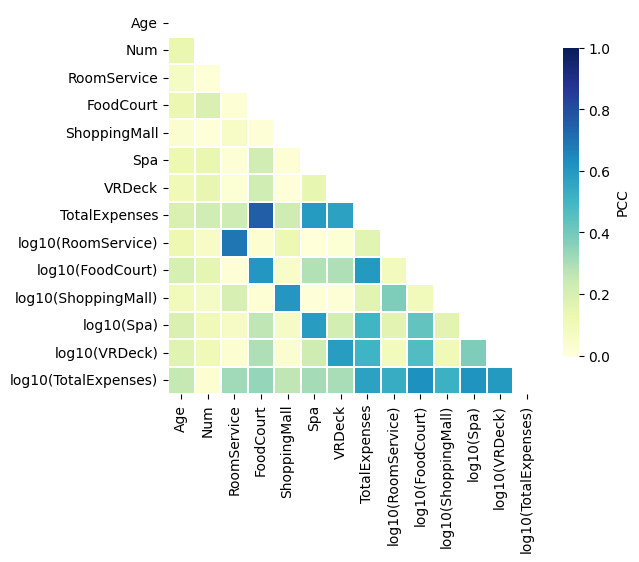

In [31]:
# correlation between quantitative features
selected_features = ['Age', 'Num'] + expense_features + ['TotalExpenses'] + expense_features_log10
df = df_train[selected_features]
df = df.dropna()

# compute the correlation matrix
corr = np.abs(df.corr())

# plot heatmap
heatmap_triangle(corr, 'PCC')

Feature 'TotalExpenses' shows correlation with several features related to expenses. It is shown a strong correlation with 'FoodCourt' and a moderate correlation with 'Spa' and 'VRDeck'.

#### Categorical features (Cramer's V test)

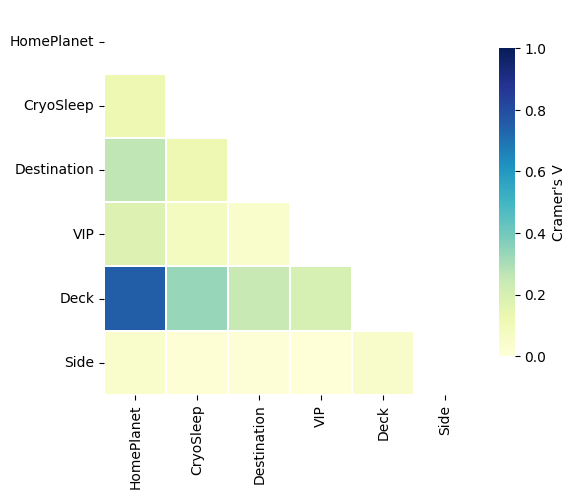

In [17]:
# relationship between categorical features (Cramer's V test)
selected_features= ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side']

scores = []
for feature1 in selected_features:
    score_feature = []
    for feature2 in selected_features:
        score_feature.append(cramers_v(df_train[feature1], df_train[feature2]))
    scores.append(score_feature)

cramer = pd.DataFrame(scores, columns = selected_features, index = selected_features)

heatmap_triangle(cramer, "Cramer's V")

Feature 'Deck' shows a strong association with 'HomePlanet'.

#### Categorical vs Numeric features (Eta squared)

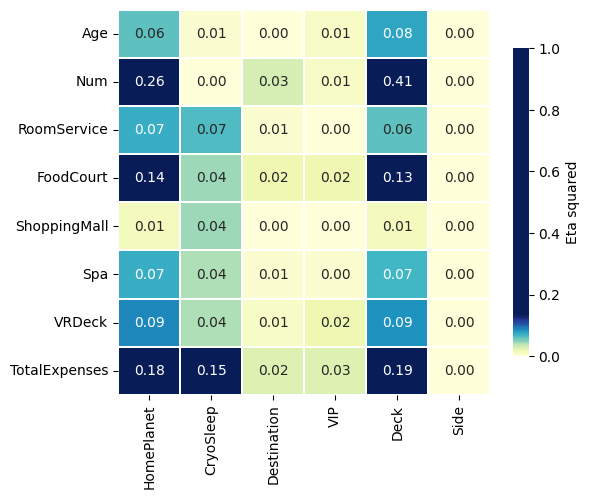

In [18]:
# relationship between quantitative vs qualitative features (Eta squared)
# TODO redo with log10 features
quant_features = ['Age', 'Num'] + expenses_features
categ_features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side']

df = df_train[categ_features + quant_features]
df = df.dropna()

df['TotalExpenses'] = df[expenses_features].sum(axis=1)
df['Num'] = df['Num'].astype(int)

scores = []
for qf in quant_features + ['TotalExpenses']:
    score_feature = []
    for cf in categ_features:
        formula = f'{qf} ~ {cf}'
        score_feature.append(eta_squared(df, formula))
    scores.append(score_feature)

eta2 = pd.DataFrame(scores, columns = categ_features, index = quant_features + ['TotalExpenses'])

heatmap_threshold(eta2, 0.14, 'Eta squared')

Feature 'Num' shows the strongest association. It shows a moderate association with 'Deck' and a weak association with 'HomePlanet'.
Feature 'FoodCourt' shows a weak association with features 'HomePlanet' and 'Deck' and 'TotalExpenses' shows a weak asociation with 'Deck', 'HomePlanet' and 'CryoSleep'.

### Correlation between target and explanatory features

#### Numerical features

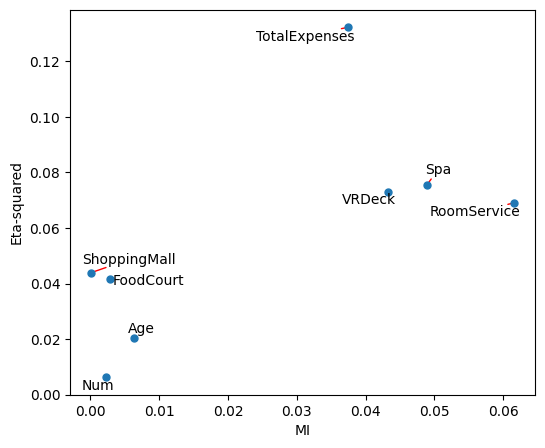

In [18]:
# relationship between quantitative features vs target (eta-squared/MI)
# TODO redo with log10 features
expenses_features = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
quant_features = ['Age', 'Num'] + expenses_features

df = df_train[quant_features + ['Transported']]
df = df.dropna()

df['TotalExpenses'] = df[expenses_features].sum(axis=1)
df['Num'] = df['Num'].astype(int)

X = df[quant_features + ['TotalExpenses']]
y = df['Transported']
mi = mutual_info_classif(X, y).tolist()
# f = f_classif(X, y)[0].tolist()
eta2 = []
for qf in quant_features + ['TotalExpenses']:
    formula = f'{qf} ~ Transported'
    eta2.append(eta_squared(df, formula))

feature_stats = {'feature': quant_features + ['TotalExpenses'], 'stat': eta2, 'mi': mi}

plot_stat_vs_mi_num(feature_stats, 'Eta-squared')

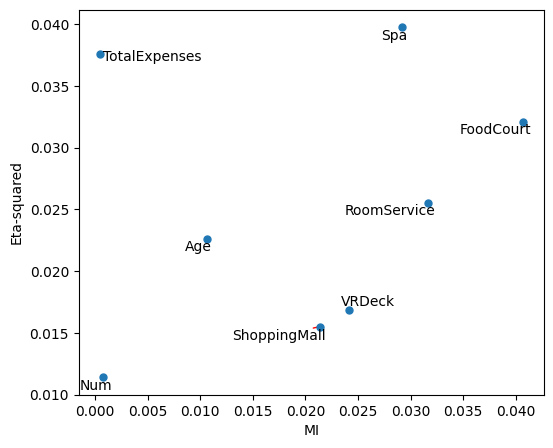

In [20]:
# relationship between quantitative features vs target (eta-squared/MI)
# remove CryoSleep True 
expenses_features = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
quant_features = ['Age', 'Num'] + expenses_features

df = df_train[quant_features + ['Transported','CryoSleep']]
df = df.dropna()
df = df[df['CryoSleep'] != True]

df['TotalExpenses'] = df[expenses_features].sum(axis=1)
df['Num'] = df['Num'].astype(int)

X = df[quant_features + ['TotalExpenses']]
y = df['Transported']
mi = mutual_info_classif(X, y).tolist()
# f = f_classif(X, y)[0].tolist()
eta2 = []
for qf in quant_features + ['TotalExpenses']:
    formula = f'{qf} ~ Transported'
    eta2.append(eta_squared(df, formula))

feature_stats = {'feature': quant_features + ['TotalExpenses'], 'stat': eta2, 'mi': mi}

plot_stat_vs_mi_num(feature_stats, 'Eta-squared')

Features related to expenses 'RoomService', 'Spa' and 'VRDeck' show highest association with target. New feature 'Total Expenses' also shows a high association.

#### Categorical features

16 [ 0.18183057 -0.46798013]
17 [-0.83076568  0.31043808]


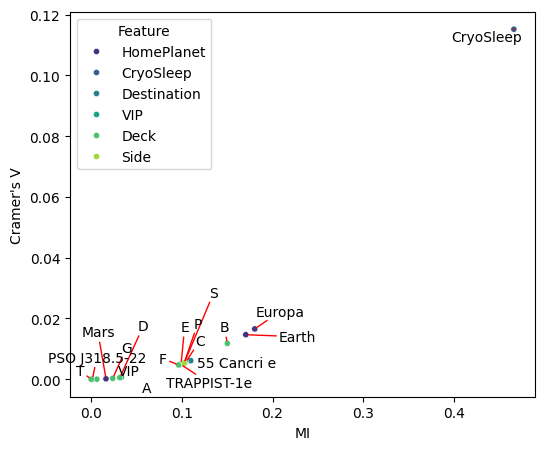

15 [-0.63332843 -0.10626814]
16 [-0.40711608  0.14600093]


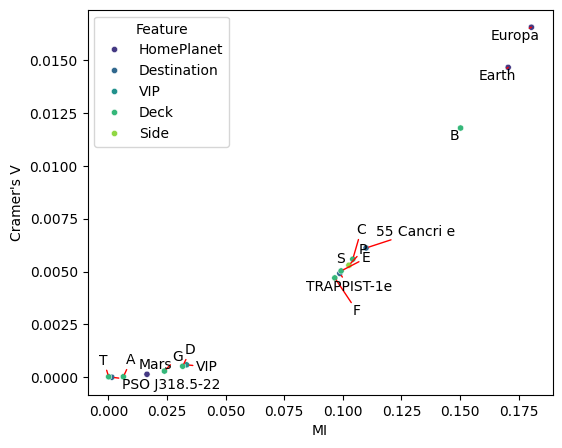

In [40]:
# relationship between categorical features vs target (Cramer's V test/MI)
categ_features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side']

df = df_train[categ_features + ['Transported']].dropna()
# one-hot encode (required for scikit-learn)
X_encoded = pd.get_dummies(df[categ_features]).drop(['VIP_False', 'CryoSleep_False'], axis=1)
y = df['Transported']

# calculate MI scores for feature selection
mi = mutual_info_classif(X_encoded, y, discrete_features=True) 

# calculate Cramer's V scores for feature selection
cramer = []
for cf in X_encoded.columns:
    cramer.append(cramers_v(X_encoded[cf], df['Transported']))

# build dataframe for plot
features_levels = list(map(lambda x: x.split('_'),X_encoded.columns))
features = list(map(lambda x: x[0], features_levels))
levels = list(map(lambda x: x[1], features_levels))
feature_stats = {'feature': features, 'level': levels, 'stat': cramer, 'mi': mi}

df = pd.DataFrame(feature_stats)
df['level'] = df.apply(lambda row: row['feature'] if row['level'] == 'True' else row['level'], axis=1)

plot_stat_vs_mi_cat(df, "Cramer's V")

df = df.query("feature != 'CryoSleep'").reset_index(drop=True)
plot_stat_vs_mi_cat(df, "Cramer's V")

'CryoSleep' feature has the highest association with the target by a wide margin. Levels 'Europa' and 'Earth' from 'HomePlanet' feature and level 'B' from 'Deck' feature show weak association with target.

### Relationship between expenses and 'CryoSleep' and 'Age' features

In [32]:
print("People with 'CryoSleep' equal to True have no expenses")
print(df_train[df_train['CryoSleep'] == True][['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].sum())
print("\nPeople with 'Age' less than 13 have no expenses")
print(df_train[df_train['Age'] < 13][['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].sum())

People with 'CryoSleep' equal to True have no expenses
RoomService     0.0
FoodCourt       0.0
ShoppingMall    0.0
Spa             0.0
VRDeck          0.0
dtype: float64

People with 'Age' equal to zero have no expenses
RoomService     0.0
FoodCourt       0.0
ShoppingMall    0.0
Spa             0.0
VRDeck          0.0
dtype: float64


### Conclusions

Features 'Num', 'Deck', and 'HomePlanet' show strong associations with each other. Meanwhile, 'FoodCourt' has a moderate association with 'Deck' and 'HomePlanet', and a strong association with 'TotalExpenses'. 

The feature 'CryoSleep' shows the strongest association with the target, while 'VRDeck', 'Spa', 'RoomService', and 'TotalExpenses' exhibit weaker associations. Among the other categorical features, 'Deck' (level B) and 'HomePlanet' (levels Europe and Earth) show some association with the target.

People with 'CryoSleep' equal to True. This could be the reason why 'TotalExpenses' and 'CryoSleep' have a high association. Also, people with 'Age' less than 13 have no expenses.

In [36]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_true = le.fit_transform(df['Transported'])  
y_pred = le.transform(df['CryoSleep'])   

df = df_train[['CryoSleep', 'Transported']].dropna()
print(pd.crosstab(df['Transported'], df['CryoSleep']))
print(classification_report(y_true, y_pred))

CryoSleep    False  True 
Transported              
False         3650    554
True          1789   2483
              precision    recall  f1-score   support

           0       0.67      0.87      0.76      4204
           1       0.82      0.58      0.68      4272

    accuracy                           0.72      8476
   macro avg       0.74      0.72      0.72      8476
weighted avg       0.74      0.72      0.72      8476



In [ ]:
# TODO New feature Age < 12 TRUE
# TODO New feature log10(RoomService) < 1 TRUE
# TODO Same for Spa, VRDeck and TotalExpenses